Image size normalization has been applied to train models in SignDetector and SymbolDetector. When predicting, same normalization has to be applied for good performance. After prediction, inverse transform has to be applied to get original image size back.

In [23]:
import numpy as np
import skimage

def get_scale_factor_max_image_size(img_np, max_img_size):
    img_shape = img_np.shape[:2]

    idx_ax_small = int(np.argmin(img_shape))
    idx_ax_large = int(np.argmax(img_shape))

    l_small = img_shape[idx_ax_small]
    l_large = img_shape[idx_ax_large]

    scale_factor = max_img_size / l_large
    return scale_factor


def get_scale_factor_min_image_size(img_np, min_img_size):
    img_shape = img_np.shape[:2]

    idx_ax_small = int(np.argmin(img_shape))
    idx_ax_large = int(np.argmax(img_shape))

    l_small = img_shape[idx_ax_small]
    l_large = img_shape[idx_ax_large]

    scale_factor = min_img_size / l_small
    return scale_factor


def resize_img_with_scale_factor(img_np, scale_factor):
    img_shape = img_np.shape[:2]

    img_shape_new = [
        int(np.round(img_shape[0] * scale_factor)),
        int(np.round(img_shape[1] * scale_factor)),
    ]

    img_new = skimage.transform.resize(
        image=img_np,
        output_shape=img_shape_new,
        preserve_range=True,
    )
    img_new = img_new.astype(np.uint8)

    return img_new


Image size, original: (1200, 1600, 3)
Image size, normalized: (512, 683, 3)
Image size, normalized inv: (1200, 1601, 3)


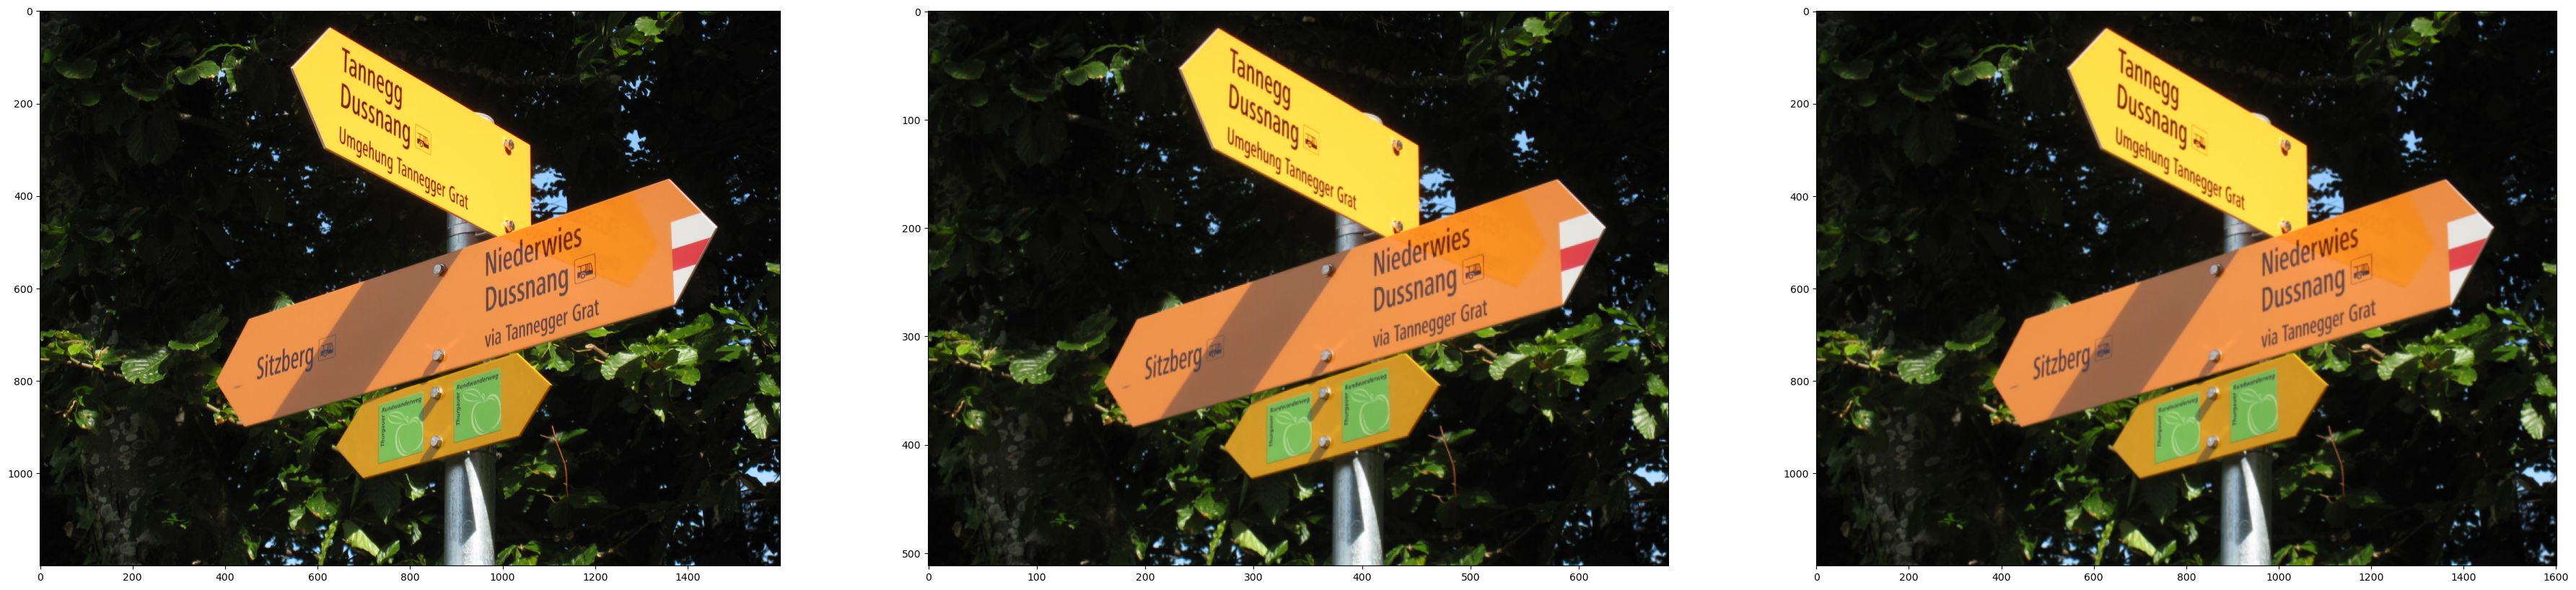

In [24]:
import signreader.utils.io as io

fname = '/Users/manu/boulot/unit_solutions/data/images/all/114451-1_4.jpg'
img_np = io.open_img_as_np_array(fname)

#max_img_size = 2560
#scale_factor = get_scale_factor_max_image_size(img_np, max_img_size)

min_img_size = 512
scale_factor = get_scale_factor_min_image_size(img_np, min_img_size)

img_norm = resize_img_with_scale_factor(img_np, scale_factor)
img_norm_inv = resize_img_with_scale_factor(img_norm, 1/scale_factor)

print(f'Image size, original: {img.shape}')
print(f'Image size, normalized: {img_norm.shape}')
print(f'Image size, normalized inv: {img_norm_inv.shape}')

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3)
axes[0].imshow(img_np)
axes[1].imshow(img_norm)
axes[2].imshow(img_norm_inv)
fig.set_figheight(15)
fig.set_figwidth(45)

Test with SignDetection:

In [25]:
def resize_mask_with_scale_factor(mask, scale_factor):
    img_shape = mask.shape[:2]

    img_shape_new = [
        int(np.round(img_shape[0] * scale_factor)),
        int(np.round(img_shape[1] * scale_factor)),
    ]

    mask_new = skimage.transform.resize(
        image=mask,
        output_shape=img_shape_new,
        preserve_range=True,
        order=0,  # for label map we have to use nearest-neighbor interpolation (default is 1: Bilinear)
    )
    return mask_new

In [26]:
from signreader.engine.sign import SignDetector
signdetector = SignDetector() # instanciate
masks_norm = signdetector(img_norm)

Image size, original: (1200, 1600, 3)
Image size, normalized: (512, 683, 3)
Mask size, normalized: (512, 683)
Mask size, normalized inv: (1200, 1600)


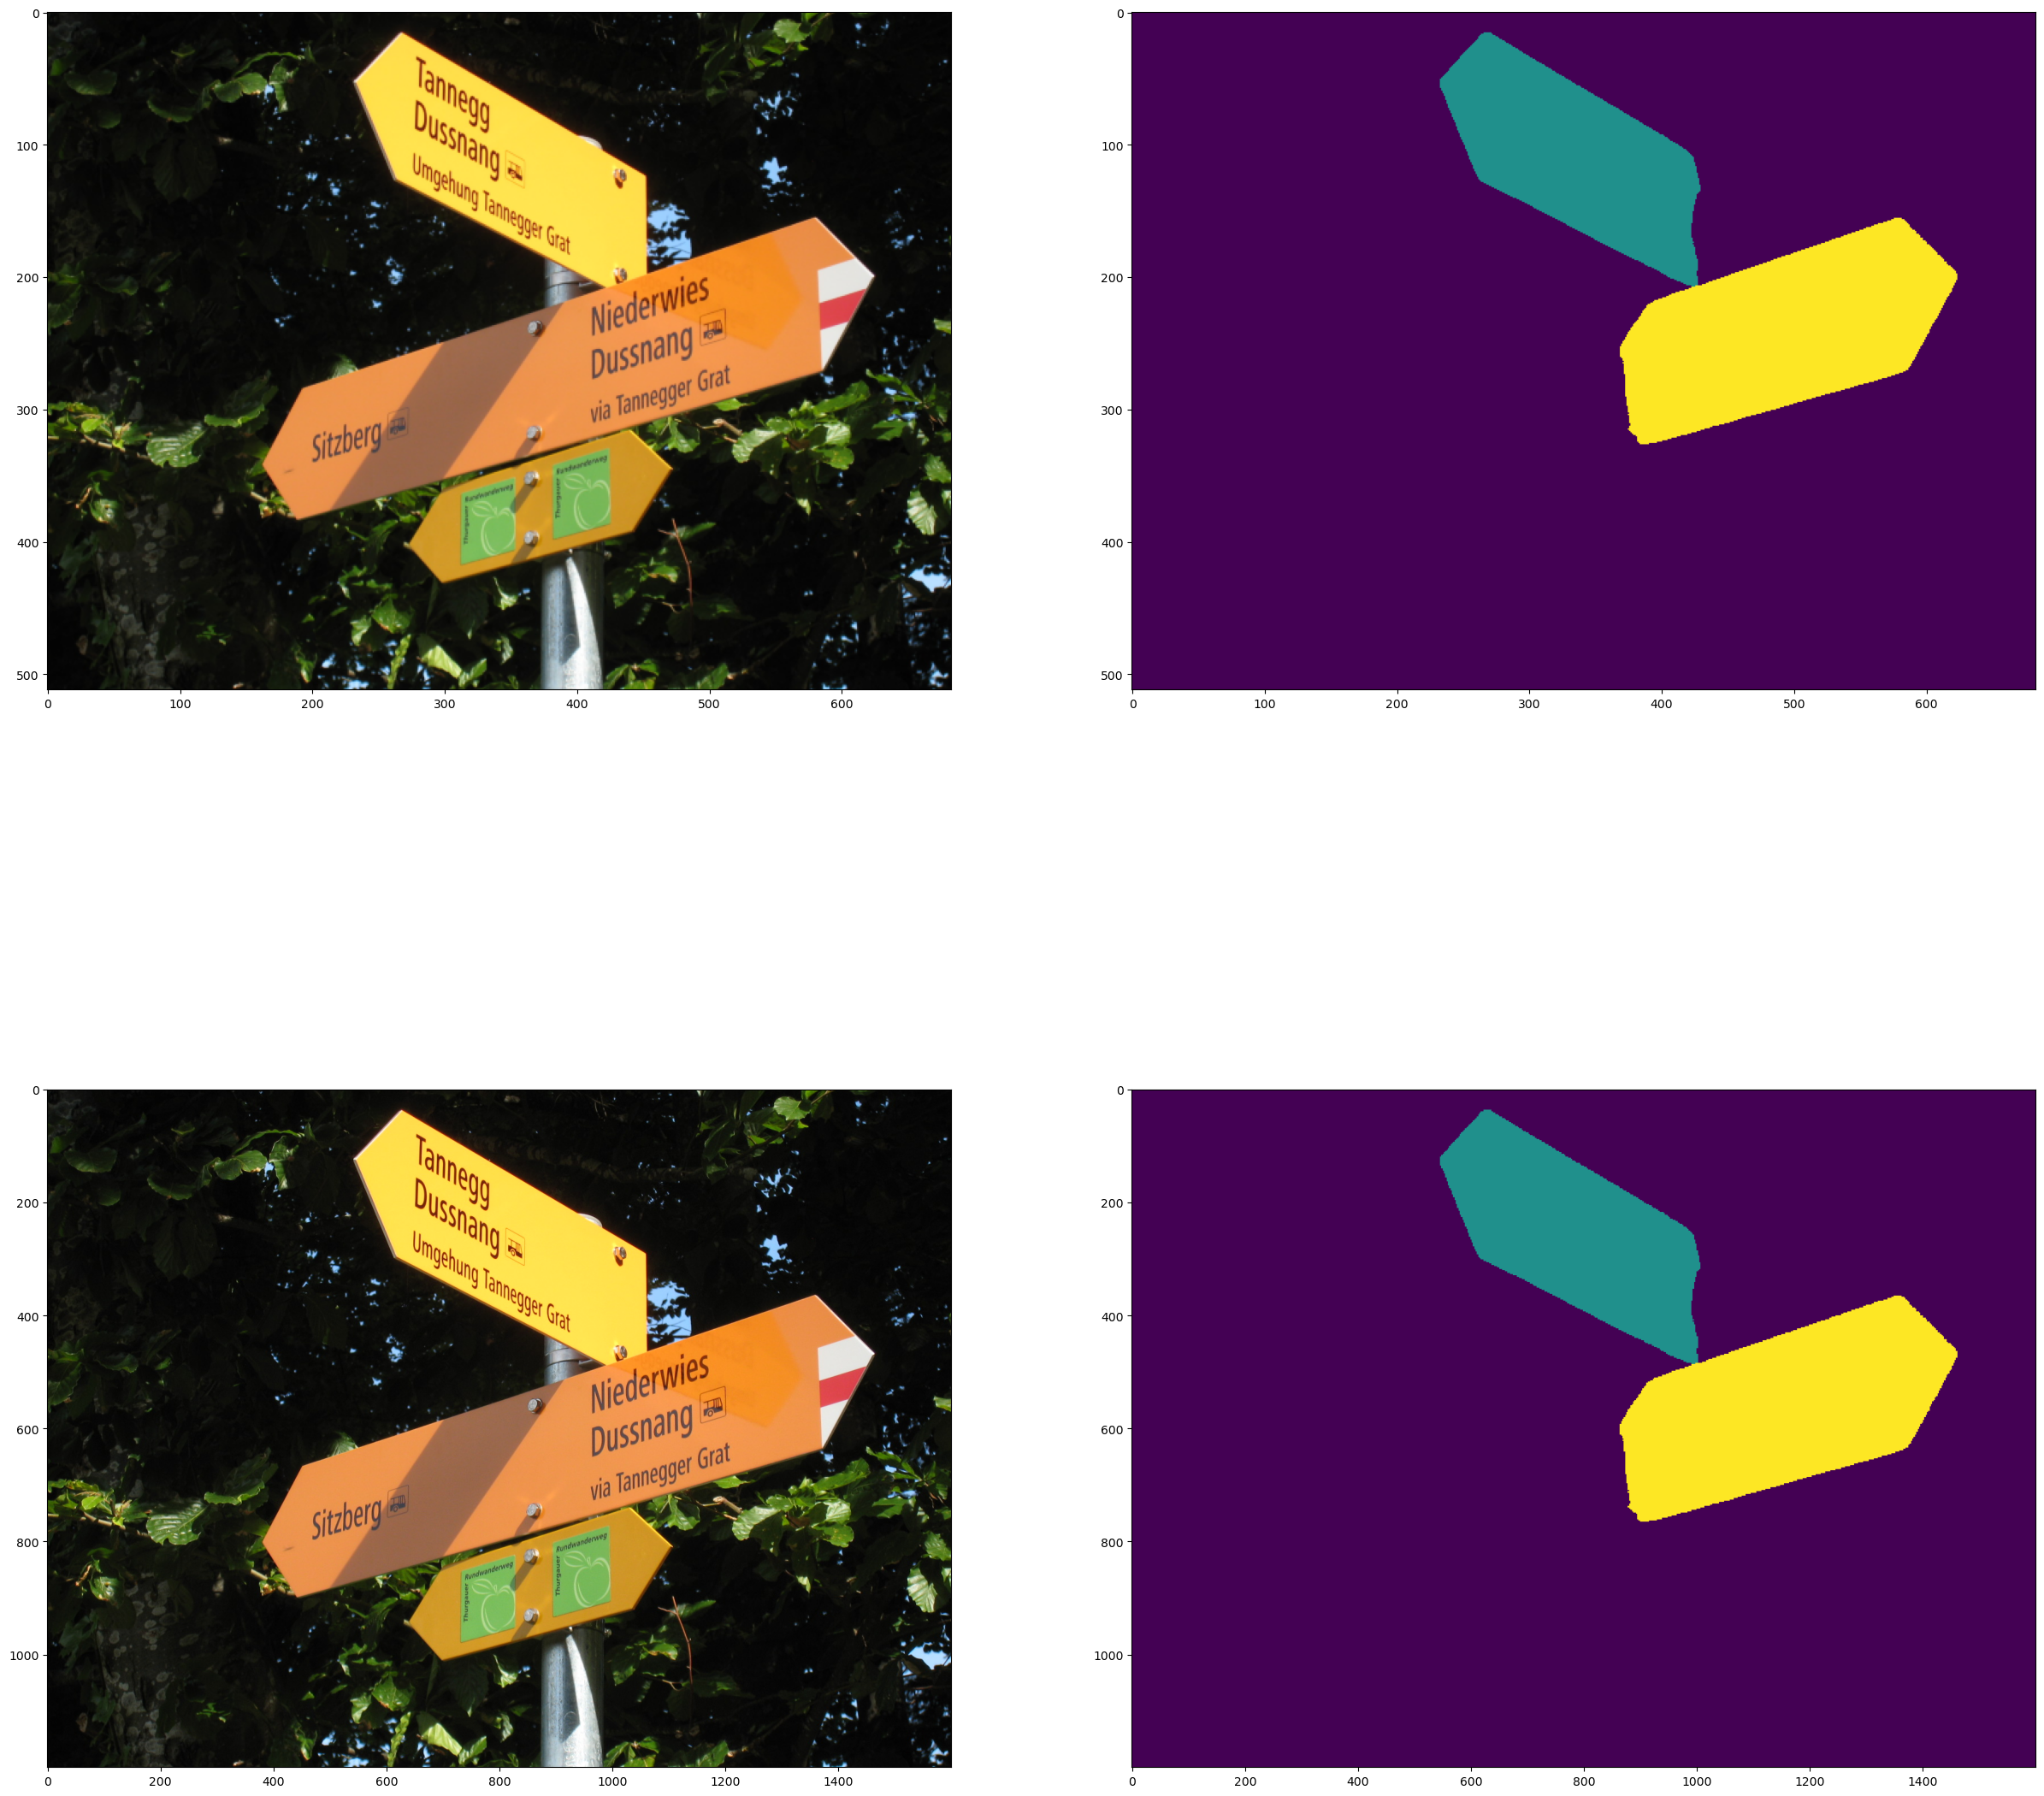

In [31]:
#masks_norm_inv = resize_mask_with_scale_factor(masks_norm, 1/scale_factor)  # if we want exact same size back, it is metter to apply skimage.transform.resize
masks_norm_inv = skimage.transform.resize(
        image=masks_norm,
        output_shape=img_np.shape[:2],
        preserve_range=True,
        order=0,  # for label map we have to use nearest-neighbor interpolation (default is 1: Bilinear)
)

print(f'Image size, original: {img.shape}')
print(f'Image size, normalized: {img_norm.shape}')
print(f'Mask size, normalized: {masks_norm.shape}')
print(f'Mask size, normalized inv: {masks_norm_inv.shape}')

fig, axes = plt.subplots(2, 2)

axes[0,0].imshow(img_norm)
axes[0,1].imshow(masks_norm)
axes[1,0].imshow(img_np)
axes[1,1].imshow(masks_norm_inv)
fig.set_figheight(30)
fig.set_figwidth(30)

Test with symbol detection:

In [32]:
max_img_size = 2560
scale_factor = get_scale_factor_max_image_size(img_np, max_img_size)
img_norm = resize_img_with_scale_factor(img_np, scale_factor)
#img_norm_inv = resize_img_with_scale_factor(img_norm, 1/scale_factor)

from signreader.engine.symbol import SymbolDetector
symbdetector = SymbolDetector()
boxes, class_names = symbdetector(img_norm)


0: 1920x2560 3 bushofs, 1484.9ms
Speed: 62.8ms preprocess, 1484.9ms inference, 17.3ms postprocess per image at shape (1, 3, 1920, 2560)


In [37]:
len(boxes)

3

In [64]:
import torch
#boxes_np = boxes.numpy()
box_list = []
for idx, box in enumerate(boxes):
    x,y,w,h = box.xywh[0]
    xn,yn,wn,hn = box.xywhn[0]
    x,y,x,y = box.xyxy[0]
    xn,yn,xn,yn = box.xyxyn[0]

    print(f'Box {idx}')
    print(f'x,y,w,h: {x},{y},{w},{h}')
    #print(f'x,y,x,y: {x*(1/scale_factor)},{y*(1/scale_factor)},{w*(1/scale_factor)},{h*(1/scale_factor)}')

    #box.xywh[0] = torch.Tensor([x*1/scale_factor, y*1/scale_factor, w*1/scale_factor, h*1/scale_factor])
    box.xywh[0][0] = x*(1/scale_factor)
    box.xywh[0][1] = y*(1/scale_factor)
    box.xywh[0][2] = w*(1/scale_factor)
    box.xywh[0][3] = h*(1/scale_factor)

    box_new = {
        'xywh': [x*1/scale_factor, y*1/scale_factor, w*1/scale_factor, h*1/scale_factor]
    }

    box_list.append(box)
    #boxes_np[idx] = box

# Check if modifs are ok:
for idx, box in enumerate(box_list):
    [x,y,w,h] = box['xywh']
    #xn,yn,wn,hn = box.xywhn[0]
    #x,y,x,y = box.xyxy[0]
    #xn,yn,xn,yn = box.xyxyn[0]

    print(f'Modified box {idx}')
    print(f'x,y,w,h: {x},{y},{w},{h}')

Box 0
x,y,w,h: 1923.377197265625,947.1878051757812,75.491943359375,105.740478515625
Box 1
x,y,w,h: 1354.08154296875,499.8095703125,57.11669921875,106.35595703125
Box 2
x,y,w,h: 1025.2657470703125,1214.421142578125,63.15087890625,93.271484375


IndexError: too many indices for tensor of dimension 2

In [55]:
1/scale_factor

0.625